In [1]:
import pandas as pd
import numpy as np
import re

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv("../data/emails.csv")

In [32]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [33]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   text    5728 non-null   str  
 1   spam    5728 non-null   int64
dtypes: int64(1), str(1)
memory usage: 89.6 KB


In [34]:
df["spam"].unique()

array([1, 0], dtype=int64)

In [35]:
df["spam"].value_counts()

spam
0    4360
1    1368
Name: count, dtype: int64

In [36]:
df["spam"].value_counts(normalize=True)

spam
0    0.761173
1    0.238827
Name: proportion, dtype: float64

Total Mail  = 5728

Dataset is Imbalanced

About 76% Not Spam and 23 % of Spam


## Class Distribution

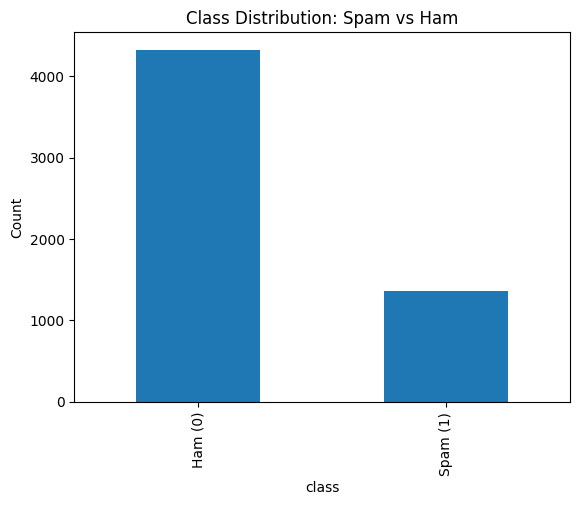

In [121]:
df["spam"].value_counts().plot(kind="bar")
plt.xticks([0,1],["Ham (0)", "Spam (1)"])
plt.title("Class Distribution: Spam vs Ham")
plt.xlabel("class")
plt.ylabel("Count")
plt.show()

In [37]:
df.duplicated().value_counts()

False    5695
True       33
Name: count, dtype: int64

In [ ]:
df.drop_duplicates(inplace = True)

In [40]:
df.columns

Index(['text', 'spam'], dtype='str')

In [41]:
df.duplicated().value_counts()

False    5695
Name: count, dtype: int64

## Clean the Text

In [82]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"subject:", "", text)     # remove 'subject:'
    text = re.sub(r"http\S+", "", text)      # remove links
    text = re.sub(r"[^a-z\s]", " ", text)    # keep letters + spaces
    text = re.sub(r"\s+", " ", text)         # FIX: collapse spaces (NOT \S+)
    return text.strip()



In [83]:
# call the clean function 
df["clean_text"] = df["text"].apply(clean_text)

## Text Length Distribution

In [123]:
df["text_length"] = df["clean_text"].apply(len)

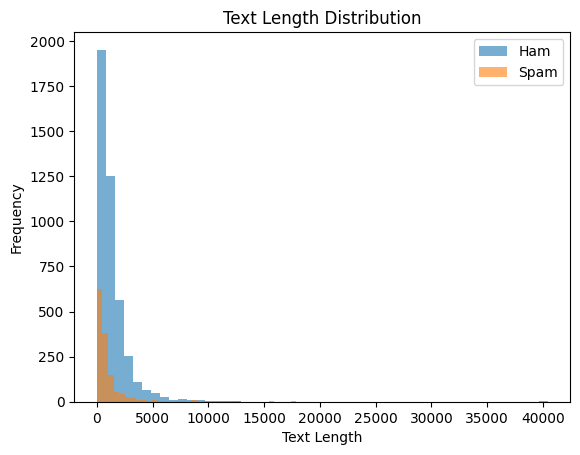

In [124]:
# Spam emails often have different lengths than ham.
plt.hist(df[df["spam"]==0]["text_length"], bins=50, alpha=0.6, label="Ham")
plt.hist(df[df["spam"]==1]["text_length"], bins=50, alpha=0.6, label="Spam")
plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.show()

In [84]:
df["clean_text"].head()

0    naturally irresistible your corporate identity...
1    the stock trading gunslinger fanny is merrill ...
2    unbelievable new homes made easy im wanting to...
3    color printing special request additional info...
4    do not have money get software cds from here s...
Name: clean_text, dtype: str

In [85]:
(df["clean_text"].str.len() == 0).sum()

0

In [86]:
df[["text","clean_text"]].info()

<class 'pandas.DataFrame'>
Index: 5695 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   text        5695 non-null   str  
 1   clean_text  5695 non-null   str  
dtypes: str(2)
memory usage: 133.5 KB


## Convert text => Number(Vectorization)

In [58]:
# Naive Bayes cannot work on raw text, so we convert text into numeric form.
# Use TF-IDF (best choice)


In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [89]:
vectorizer = TfidfVectorizer(
    stop_words="english",
    min_df = 2
)

In [90]:
X = vectorizer.fit_transform(df["clean_text"])
y = df["spam"]

In [91]:
X.shape

(5695, 18202)

In [93]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 443022 stored elements and shape (5695, 18202)>

## Train Naive Bayes

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.2,random_state=42,stratify=y)

tratify=y keeps spam ratio balanced.

In [98]:
from sklearn.naive_bayes import MultinomialNB

In [102]:
nb_model = MultinomialNB()

In [103]:
nb_model.fit(X_train,y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [104]:
y_pred = nb_model.predict(X_test)

## Evualute

In [109]:
from sklearn.metrics  import accuracy_score, confusion_matrix,classification_report

In [110]:
print("Accuray: ", accuracy_score(y_test,y_pred))

Accuray:  0.9569798068481123


In [111]:
print("Confusion matrix\n", confusion_matrix(y_test,y_pred))

Confusion matrix
 [[865   0]
 [ 49 225]]


In [126]:
cm = confusion_matrix(y_test, y_pred)

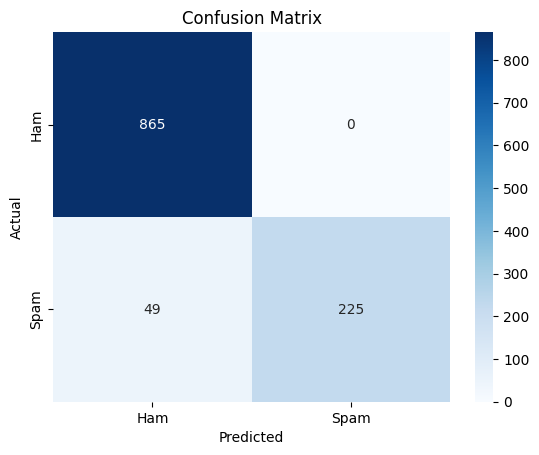

In [127]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham", "Spam"],
            yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [112]:
print("Classifcation Report \n", classification_report(y_test,y_pred))

Classifcation Report 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       865
           1       1.00      0.82      0.90       274

    accuracy                           0.96      1139
   macro avg       0.97      0.91      0.94      1139
weighted avg       0.96      0.96      0.96      1139



### overfitting & Underfitting 

In [115]:
# Check Training VS Test Accuray
# Training Accuray
y_train_pred = nb_model.predict(X_train)
train_acc = accuracy_score(y_train,y_train_pred)

In [117]:
# Test Accuracy
y_test_pred = nb_model.predict(X_test)
test_acc = accuracy_score(y_test,y_test_pred)

In [118]:
print("Training Accuracy : ", train_acc)
print("Test Accuracy : ", test_acc)

Training Accuracy :  0.9754170324846356
Test Accuracy :  0.9569798068481123


## Learning Curve (Overfitting / Underfitting)

In [128]:
from sklearn.model_selection import learning_curve

In [129]:
train_sizes, train_scores, test_scores = learning_curve(
    nb_model, X, y, cv=5, scoring="accuracy"
)

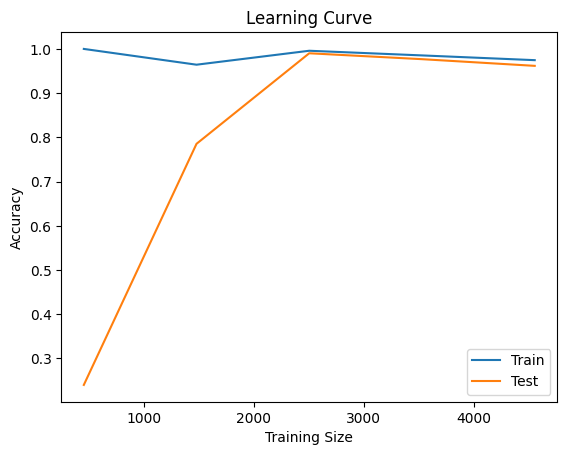

In [131]:
plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), label="Test")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Learning Curve")
plt.show()

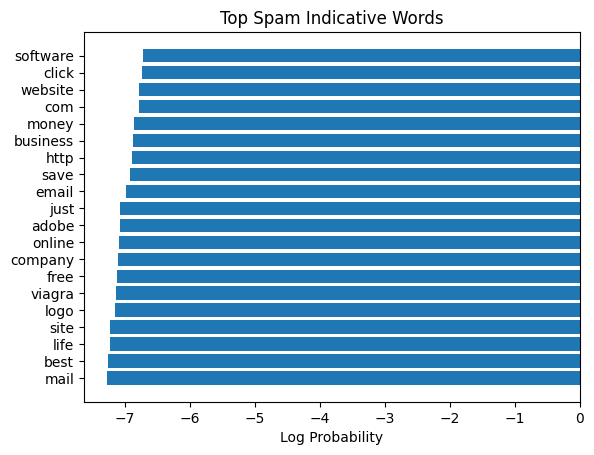

In [140]:
feature_names = vectorizer.get_feature_names_out()
spam_prob = nb_model.feature_log_prob_[1]

top_spam = sorted(
    zip(feature_names, spam_prob),
    key=lambda x: x[1],
    reverse=True
)[:20]

words, scores = zip(*top_spam)

plt.barh(words, scores)
plt.xlabel("Log Probability")
plt.title("Top Spam Indicative Words")
plt.gca().invert_yaxis()
plt.show()


## Check for the New Data 

In [149]:
new_mail =  "Congratulations! You have won a free lottery ticket"

#clean
cleaned = clean_text(new_mail)
# Vectorized
Vectorized = vectorizer.transform([cleaned])

# predict
prediction = nb_model.predict(Vectorized)
probability = nb_model.predict_proba(Vectorized)


In [150]:
print("Prediction:", "Spam" if prediction[0]==1 else "Not Spam")
print("Spam Probability: ", probability[0][1])

Prediction: Not Spam
Spam Probability:  0.26434512282346156


## Cross Validataion 

In [152]:
from sklearn.model_selection import cross_val_score

In [154]:
cv_f1 = cross_val_score(
    nb_model,
    X,
    y,
    cv=5,
    scoring="f1"
)

In [155]:
print("CV F1 Scores: ",cv_f1)
print("Mean CV F1: ",cv_f1.mean())

CV F1 Scores:  [0.89112903 0.91304348 0.9254902  0.89959839 0.93774319]
Mean CV F1:  0.9134008581666283


## save the model 

In [156]:
import pickle

In [159]:
# Save Model
with open("../models/Spam_nb_model.pkl","wb") as f:
    pickle.dump(nb_model,f)

# save vectorizer
with open("../models/tfidf_vectorizer.pkl","wb") as f:
    pickle.dump(vectorizer, f)